# Kalshi NYC Temperature Market — Raw Data Exploration

This notebook helps you understand how the **raw Kalshi data** for NYC high-temperature prediction markets works. We'll load the JSON files, parse their structure, and visualize what the market is telling us.

## What is Kalshi?

Kalshi is a regulated prediction market (CFTC) where people trade on outcomes. For weather, you're betting on things like *"Will the high temp in NYC be between 32°–33° on Feb 4, 2026?"* Each contract pays $1 if the outcome is **Yes**, and $0 if **No**. Prices are in **cents** (1–99), so 45¢ means the market implies ~45% probability.

## 1. Raw Data File Structure

The `data/raw/kalshi/` folder contains two types of files:

| File Type | Naming Pattern | Contents |
|-----------|----------------|----------|
| **Event Markets** | `KXHIGHNY-26FEB04_20260212_021232_event_markets.json` | Event meta + list of all markets (one per temp range) |
| **Orderbook** | `KXHIGHNY-26FEB04-B32.5_20260212_021232_orderbook.json` | Bids/asks for a single market ticker |

**Ticker naming:**
- `KXHIGHNY-26FEB04` = NYC high temp event for Feb 4, 2026
- `B32.5` = "Between" 32–33° (the decimal is the midpoint)
- `T36` = "Top" — 36° or above
- `T30` = "Top" of low range — 29° or below (less than 30°)

In [1]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Run this notebook from the exploration/ directorya
KALSHI_DIR = Path(".") / "data" / "raw" / "kalshi"

# List files by type
event_files = sorted(KALSHI_DIR.glob("*_event_markets.json"))
orderbook_files = sorted(KALSHI_DIR.glob("*_orderbook.json"))
print(f"Event market files: {len(event_files)}")
print(f"Orderbook files: {len(orderbook_files)}")
print("\nSample event files:")
for f in event_files[:5]:
    print(f"  {f.name}")

Event market files: 12
Orderbook files: 69

Sample event files:
  KXHIGHNY-26FEB04_20260212_021232_event_markets.json
  KXHIGHNY-26FEB05_20260212_021237_event_markets.json
  KXHIGHNY-26FEB06_20260212_021243_event_markets.json
  KXHIGHNY-26FEB07_20260212_021248_event_markets.json
  KXHIGHNY-26FEB08_20260212_021155_event_markets.json


## 2. Event Markets JSON Structure

Each `*_event_markets.json` has:
- `event_ticker` — e.g. KXHIGHNY-26FEB04
- `date` — the date the market resolves for
- `markets` — list of individual markets, one per temperature range

Each **market** has:
- `ticker` — e.g. KXHIGHNY-26FEB04-B32.5
- `subtitle` — human-readable range (e.g. "32° to 33°")
- `yes_bid` / `yes_ask` — best bid/ask in cents (implied probability)
- `last_price` — last trade price
- `status` — `active` or `finalized`
- `result` — `yes` or `no` when finalized
- `expiration_value` — the actual high temp (when resolved)
- `volume`, `open_interest`, `liquidity` — trading activity

In [2]:
# Load one event file
sample_event = event_files[0]
with open(sample_event) as f:
    event = json.load(f)

print(f"Event: {event['event_ticker']}")
print(f"Date: {event['date']}")
print(f"Markets: {len(event['markets'])}")

# Show first market
m = event['markets'][0]
print("\n--- First market keys ---")
print(list(m.keys())[:20])

print("\n--- First market (sample) ---")
print(json.dumps({k: m[k] for k in ['ticker', 'subtitle', 'yes_bid', 'yes_ask', 'last_price', 'status', 'result', 'expiration_value']}, indent=2))

Event: KXHIGHNY-26FEB04
Date: 2026-02-04
Markets: 6

--- First market keys ---
['can_close_early', 'cap_strike', 'close_time', 'created_time', 'early_close_condition', 'event_ticker', 'expected_expiration_time', 'expiration_time', 'expiration_value', 'last_price', 'last_price_dollars', 'latest_expiration_time', 'liquidity', 'liquidity_dollars', 'market_type', 'no_ask', 'no_ask_dollars', 'no_bid', 'no_bid_dollars', 'no_sub_title']

--- First market (sample) ---
{
  "ticker": "KXHIGHNY-26FEB04-T30",
  "subtitle": "29\u00b0 or below",
  "yes_bid": 0,
  "yes_ask": 100,
  "last_price": 1,
  "status": "finalized",
  "result": "no",
  "expiration_value": "33.00"
}


## 3. Build a DataFrame of All Markets

We'll extract key fields from each event file and build a table for analysis.

In [3]:
def load_all_event_markets(event_files):
    """Load all event files and flatten into a DataFrame."""
    rows = []
    for path in event_files:
        with open(path) as f:
            event = json.load(f)
        event_ticker = event["event_ticker"]
        date = event["date"]
        # Use only the most recent snapshot per event (last file wins)
        for m in event["markets"]:
            rows.append({
                "event_ticker": event_ticker,
                "date": date,
                "ticker": m["ticker"],
                "subtitle": m["subtitle"],
                "yes_bid": m.get("yes_bid"),
                "yes_ask": m.get("yes_ask"),
                "last_price": m.get("last_price"),
                "status": m.get("status"),
                "result": m.get("result", ""),
                "expiration_value": m.get("expiration_value", ""),
                "volume": m.get("volume"),
                "open_interest": m.get("open_interest"),
                "liquidity": m.get("liquidity"),
                "strike_type": m.get("strike_type"),
                "source_file": path.name,
            })
    return pd.DataFrame(rows)

df = load_all_event_markets(event_files)

# Deduplicate: keep latest snapshot per ticker (by source file timestamp)
df = df.sort_values("source_file", ascending=False).drop_duplicates(subset=["ticker"], keep="first")
df = df.sort_values(["date", "ticker"])

# Build time-series df (all snapshots, no dedup) for probability-over-time charts
import re
df_ts = load_all_event_markets(event_files)
def parse_snapshot_time(name):
    m = re.search(r"_(\d{8})_(\d{6})_", name)
    if m:
        return pd.to_datetime(f"{m.group(1)}{m.group(2)}", format="%Y%m%d%H%M%S")
    return pd.NaT
df_ts["snapshot_time"] = df_ts["source_file"].apply(parse_snapshot_time)
df_ts = df_ts.dropna(subset=["snapshot_time"])

print(f"Total rows: {len(df)}")
print(f"Unique dates: {df['date'].nunique()}")
print(f"Time-series rows (all snapshots): {len(df_ts)}")
df.head(10)

Total rows: 48
Unique dates: 8
Time-series rows (all snapshots): 72


,event_ticker,date,ticker,subtitle,yes_bid,yes_ask,last_price,status,result,expiration_value,volume,open_interest,liquidity,strike_type,source_file
1,KXHIGHNY-26FEB04,2026-02-04,KXHIGHNY-26FEB04-B30.5,30° to 31°,0,100,1,finalized,no,33.00,121544,79282,0,between,KXHIGHNY-26FEB04_20260212_021232_event_markets...
2,KXHIGHNY-26FEB04,2026-02-04,KXHIGHNY-26FEB04-B32.5,32° to 33°,0,100,99,finalized,yes,33.00,48731,22804,0,between,KXHIGHNY-26FEB04_20260212_021232_event_markets...
3,KXHIGHNY-26FEB04,2026-02-04,KXHIGHNY-26FEB04-B34.5,34° to 35°,0,100,1,finalized,no,33.00,41036,16640,0,between,KXHIGHNY-26FEB04_20260212_021232_event_markets...
4,KXHIGHNY-26FEB04,2026-02-04,KXHIGHNY-26FEB04-B36.5,36° to 37°,0,100,1,finalized,no,33.00,13115,8411,0,between,KXHIGHNY-26FEB04_20260212_021232_event_markets...
0,KXHIGHNY-26FEB04,2026-02-04,KXHIGHNY-26FEB04-T30,29° or below,0,100,1,finalized,no,33.00,39750,35869,0,less,KXHIGHNY-26FEB04_20260212_021232_event_markets...
5,KXHIGHNY-26FEB04,2026-02-04,KXHIGHNY-26FEB04-T37,38° or above,0,100,1,finalized,no,33.00,8697,7838,0,greater,KXHIGHNY-26FEB04_20260212_021232_event_markets...
7,KXHIGHNY-26FEB05,2026-02-05,KXHIGHNY-26FEB05-B29.5,29° to 30°,0,100,1,finalized,no,32.00,113256,64805,0,between,KXHIGHNY-26FEB05_20260212_021237_event_markets...
8,KXHIGHNY-26FEB05,2026-02-05,KXHIGHNY-26FEB05-B31.5,31° to 32°,0,100,99,finalized,yes,32.00,92595,42199,0,between,KXHIGHNY-26FEB05_20260212_021237_event_markets...
9,KXHIGHNY-26FEB05,2026-02-05,KXHIGHNY-26FEB05-B33.5,33° to 34°,0,100,1,finalized,no,32.00,78103,31361,0,between,KXHIGHNY-26FEB05_20260212_021237_event_markets...
10,KXHIGHNY-26FEB05,2026-02-05,KXHIGHNY-26FEB05-B35.5,35° to 36°,0,100,1,finalized,no,32.00,15625,11342,0,between,KXHIGHNY-26FEB05_20260212_021237_event_markets...


## 4. Interpret the Columns

| Column | Meaning |
|--------|--------|
| `yes_bid` | Best price someone will pay for a "Yes" contract (1–99 cents). Implies "market thinks probability is at least X%" |
| `yes_ask` | Best price someone will sell a "Yes" for. Implies "market thinks probability is at most X%" |
| `last_price` | Last traded price. Often used as a "mid" estimate |
| `result` | "yes" or "no" — only set when the market is finalized |
| `expiration_value` | Actual NWS high temp (when resolved) — used to show which market won |
| `volume` | Total contracts traded |
| `open_interest` | Contracts still held (not closed) |
| `liquidity` | Total $ available at best bid/ask |

In [4]:
# Show finalized markets and their outcome
finalized = df[df["status"] == "finalized"].copy()
winner = finalized[finalized["result"] == "yes"]
print("\n--- Finalized markets: which contract won? ---")
for _, row in winner.iterrows():
    print(f"  {row['date']}: {row['subtitle']} (actual high: {row['expiration_value']}°F)")


--- Finalized markets: which contract won? ---
  2026-02-04: 32° to 33° (actual high: 33.00°F)
  2026-02-05: 31° to 32° (actual high: 32.00°F)
  2026-02-06: 32° to 33° (actual high: 33.00°F)
  2026-02-07: 26° to 27° (actual high: 27.00°F)
  2026-02-08: 17° to 18° (actual high: 18.00°F)
  2026-02-09: 30° to 31° (actual high: 31.00°F)
  2026-02-10: 36° to 37° (actual high: 37.00°F)


## 5. Visualization: Implied Probability by Temperature Range

For each day, we show the market's implied probability for each temperature bin. The winning bin (when finalized) should have probability near 1.

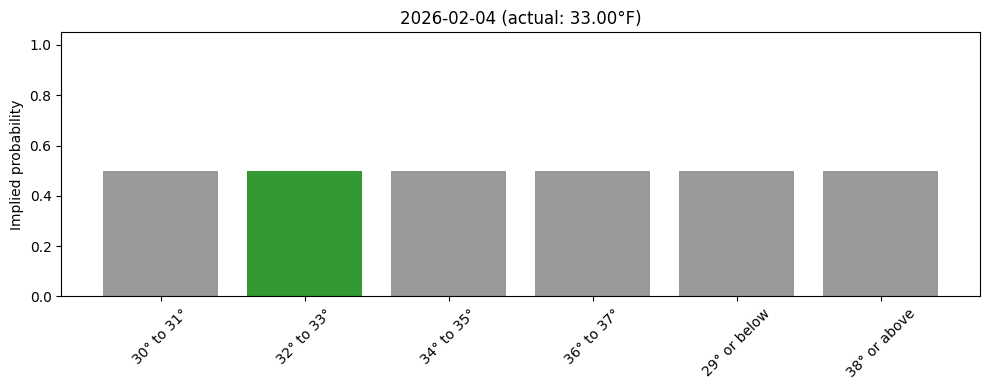

In [5]:
def plot_implied_probs(df, date_filter=None):
    """Plot implied probability (mid of bid/ask) by temperature range for each date."""
    subset = df.copy()
    if date_filter:
        subset = subset[subset["date"] == date_filter]
    
    # Compute mid probability
    def mid_prob(row):
        b, a = row["yes_bid"], row["yes_ask"]
        if pd.notna(b) and pd.notna(a):
            return (b + a) / 2
        return row["last_price"] if pd.notna(row["last_price"]) else None
    
    subset = subset.assign(mid_prob=subset.apply(mid_prob, axis=1))
    subset = subset.assign(mid_prob=subset["mid_prob"].fillna(subset["last_price"]))
    subset = subset.dropna(subset=["mid_prob"])
    
    dates = subset["date"].unique()
    if len(dates) == 0:
        print("No data for plotting")
        return
    
    fig, axes = plt.subplots(len(dates), 1, figsize=(10, 4 * len(dates)), squeeze=False)
    for i, date in enumerate(dates):
        ax = axes[i, 0]
        d = subset[subset["date"] == date]
        colors = ["green" if r == "yes" else "gray" if r else "steelblue" for r in d["result"]]
        bars = ax.bar(d["subtitle"], d["mid_prob"] / 100, color=colors, alpha=0.8)
        ax.set_ylabel("Implied probability")
        ax.set_title(f"{date}" + (f" (actual: {d['expiration_value'].iloc[0]}°F)" if d["expiration_value"].iloc[0] else ""))
        ax.set_ylim(0, 1.05)
        ax.tick_params(axis="x", rotation=45)
    plt.tight_layout()
    plt.show()

# Plot a few dates
plot_implied_probs(df, date_filter="2026-02-04")

## 6. Orderbook Structure

The `*_orderbook.json` files contain live order depth:
- `yes` / `no` — lists of `[price_cents, quantity]`
- `yes` = people willing to buy/sell "Yes" contracts
- `no` = people willing to buy/sell "No" contracts

When a market is **finalized**, the orderbook is often empty (null). For **active** markets, you see depth.

In [6]:
import plotly.express as px
from ipywidgets import interact, Dropdown

def mid_prob(row):
    b, a = row["yes_bid"], row["yes_ask"]
    if pd.notna(b) and pd.notna(a):
        return (b + a) / 2
    return row["last_price"] if pd.notna(row["last_price"]) else None

df_ts_plot = df_ts.copy()
df_ts_plot["mid_prob"] = df_ts_plot.apply(mid_prob, axis=1)
df_ts_plot["mid_prob"] = df_ts_plot["mid_prob"].fillna(df_ts_plot["last_price"])
df_ts_plot = df_ts_plot.dropna(subset=["mid_prob", "snapshot_time"])

# Dates that have multiple snapshots
dates_with_changes = df_ts_plot.groupby("date").agg({"snapshot_time": "nunique"}).query("snapshot_time > 1").index.tolist()
if not dates_with_changes:
    dates_with_changes = df_ts_plot["date"].unique().tolist()

def plot_probability_timeline(date_filter):
    subset = df_ts_plot[df_ts_plot["date"] == date_filter].copy()
    if subset.empty:
        print("No data for this date.")
        return
    subset = subset.sort_values(["snapshot_time", "subtitle"])
    subset = subset.assign(prob_pct=subset["mid_prob"] / 100)
    
    # Use full 24-hour day for x-axis (data may only span minutes in one run)
    snap_dates = subset["snapshot_time"].dt.date
    day_start = pd.Timestamp(min(snap_dates))
    day_end = pd.Timestamp(max(snap_dates)) + pd.Timedelta(days=1)
    x_range = [day_start, day_end]
    
    fig = px.line(
        subset,
        x="snapshot_time",
        y="prob_pct",
        color="subtitle",
        title=f"Implied probability over time — {date_filter}",
        labels={"prob_pct": "Implied probability", "snapshot_time": "Snapshot time"},
    )
    fig.update_layout(
        xaxis=dict(range=x_range, dtick=3600000 * 2),  # 2-hour ticks
        yaxis=dict(tickformat=".0%", range=[0, 1.05]),
        hovermode="x unified",
        legend_title="Temp range",
    )
    fig.update_traces(mode="lines+markers")
    fig.show()

interact(plot_probability_timeline, date_filter=Dropdown(options=dates_with_changes, description="Date:"))

interactive(children=(Dropdown(description='Date:', options=('2026-02-08', '2026-02-09', '2026-02-10', '2026-0…

<function __main__.plot_probability_timeline(date_filter)>

In [7]:
# Find ALL orderbooks with data (many finalized markets have null orderbooks)
ob_files_with_data = []
for p in orderbook_files:
    with open(p) as f:
        ob = json.load(f)
    ob_data = ob.get("orderbook", ob)
    yes_ob = ob_data.get("yes")
    no_ob = ob_data.get("no")
    if yes_ob or no_ob:
        ob_files_with_data.append(p)

print(f"Found {len(ob_files_with_data)} orderbooks with data")
if ob_files_with_data:
    print("Sample:", ob_files_with_data[0].name)

Found 12 orderbooks with data
Sample: KXHIGHNY-26FEB11-B36.5_20260212_021211_orderbook.json


## 7. Orderbook Depth Visualization

When we have orderbook data, we can plot bid/ask depth. The "no" side: each row is `[price_cents, quantity]`. Higher price = more willing to pay for "No" = more confident the outcome won't happen.

In [8]:
from ipywidgets import interact, Dropdown

def plot_orderbook(ob_path, use_log_scale=True):
    """Plot order depth. Uses log scale for quantity when range is large so small orders are visible."""
    with open(ob_path) as f:
        ob = json.load(f)
    ob_data = ob.get("orderbook", ob)
    yes_ob = ob_data.get("yes")
    no_ob = ob_data.get("no")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    def _plot_side(ax, ob_data, color, title):
        if not ob_data:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
            return
        prices, qtys = zip(*ob_data)
        qtys = list(qtys)
        # Use log scale when max/min > 50 so small orders are visible
        if use_log_scale and max(qtys) / max(min(qtys), 1) > 50:
            qtys = [max(q, 0.5) for q in qtys]  # avoid log(0)
            ax.barh(range(len(prices)), qtys, color=color, alpha=0.7)
            ax.set_xscale("log")
        else:
            ax.barh(range(len(prices)), qtys, color=color, alpha=0.7)
        ax.set_yticks(range(len(prices)))
        ax.set_yticklabels([f"{p}¢" for p in prices], fontsize=9)
        ax.set_xlabel("Quantity (contracts)")
        ax.set_title(title)
        ax.invert_yaxis()  # best price at top
    
    _plot_side(axes[0], no_ob, "coral", "No side (bet against outcome)")
    _plot_side(axes[1], yes_ob, "teal", "Yes side (bet outcome happens)")
    
    if not yes_ob and not no_ob:
        axes[0].text(0.5, 0.5, "No orderbook data", ha="center", va="center", transform=axes[0].transAxes)
    plt.suptitle(ob_path.name, fontsize=10)
    plt.tight_layout()
    plt.show()

if ob_files_with_data:
    ob_options = {p.name: p for p in ob_files_with_data}
    interact(lambda p: plot_orderbook(ob_options[p]), p=Dropdown(options=list(ob_options.keys()), description="Orderbook:"))
else:
    print("No orderbook with data found (all markets may be finalized)")

interactive(children=(Dropdown(description='Orderbook:', options=('KXHIGHNY-26FEB11-B36.5_20260212_021211_orde…

## 8. Summary: What You're Seeing

### Event Markets
- **One event per date** (e.g. Feb 4, 2026)
- **One market per temperature bin** (e.g. 29° or below, 30–31°, 32–33°, …)
- **Exactly one** market resolves **Yes** for each date (the bin containing the actual high)
- `yes_bid` / `yes_ask` = implied probability that this bin wins
- `expiration_value` = actual NWS high when resolved

### Orderbooks
- **One orderbook per market ticker** (e.g. KXHIGHNY-26FEB04-B32.5)
- `yes` / `no` = price levels and quantities
- Empty when market is finalized (no more trading)

### Resolution
Kalshi uses the **NWS Climatological Report (Daily)** for Central Park (KNYC). The official high is rounded to the nearest whole °F. See `project_rules/weather_prediction_rules.md` for details.